# TP2 - Market Basket Analysis 
INF8111 - Fouille de données, Summer 2020
### Team Components
    - Sabzi Dizajyekan (2078921) 1
    - Desclaux  (2097696) 2
    - Berrais-Sanchez  (2092882) 3


## Delivery date and instructions
You should upload the file named TP2\_nameOfMember1\_nameOfMember2\_nameOfMember3.ipynb on moodle.


## Market Basket Analysis

Market Basket Analysis (MBA) is a data mining analytics technique to uncover associations between products or product grouping. By exploring interesting patterns from an extensive collection of data, MBA aims to understand/reveal customer purchase behaviors based upon the theory that if you purchased a certain set of products, then you are more (or less) likely to buy another group of products. In other words, MBA allows retailers to identify the relationship between the items that customers buy, revealing patterns of items often purchased together.

A widely used approach to explore these patterns is by constructing ***association rules*** such as
- **if** bought *ITEM_1* **then** will buy *ITEM_2* with **confidence** *X*.

These associations do not have to be 1-to-1 rules. They can involve many items. For example, a person in a supermarket may add eggs to his/her cart, then an MBA application may suggest that the person will also buy some bread and/or flour: 

+ **if** bought *EGGS* **then** will buy [*BREAD* with confidence *0.2*; *FLOUR* with confidence 0.05].

However, if the person now decides to add flour to his/her cart, the new association rule could be as showing below, suggesting ingredients to make a cake.

+ **if** bought [*EGGS, FLOUR*] **then** will buy [*SUGGAR* with confidence 0.45; BAKING POWDER with confidence 0.12; *BREAD* with confidence *0.03*].

There are many real scenarios where MBA plays a central role in data analysis, such as supermarket transactions, online orders or credit card history. Marketers may use these association rules to arrange correlated products closer to each other on store shelves or make online suggestions so that customers buy more items. Some questions that an MBA can usually help retailers to answer are:

- What items are often purchased together?
- Given a basket, what items should be suggested?
- How should items be placed together on the shelves?

### Objective

Your goal in this TP is to develop an MBA algorithm for revealing patterns by creating association rules in a big dataset with more than three million supermarket transactions. However, mining association rules for large datasets is a very computationally intensive problem, which makes it almost impractical to perform it without a distributed system. Hence, to run your algorithm, you will have access to a distributed cloud computing cluster with hundreds of cores. 

To this end, a **MapReduce** algorithm will be implemented upon the [Apache Spark](http://spark.apache.org) framework, a fast cluster computing system. In a nutshell, Spark is an open source framework designed with a *scale-out* methodology which makes it a very powerful tool for programmers or application developers to perform a massive volume of computations and data processing in distributed environments. Spark provides high-level APIs that make it easy to build parallel apps without needing to worry about how your code and data are parallelized/distributed thought the computing cluster. Spark does it all for you.

The implementation will follow the Market Basket Analysis algorithm presented by Jongwook Woo and Yuhang Xu (2012). The image **workflow.pdf** Illustrates the algorithm's workflow, and is to be used for consultation throughout this TP. The blue boxes are the ones where you must implement a method to perform a map or reduce function, and the gray boxes represent their expected output. **All these operations are explained in detail in the following sections.** 


## 1. Setting up Spark

Spark runs on both Windows and UNIX-like systems (e.g., Linux, Mac OS). It's easy to run locally on one machine — all you need is to have Java installed on your system PATH, or the JAVA_HOME environment variable pointing to a Java installation. It is mandatory that you have the **JDK v8** installed in your system, as Spark currently only support this version. If you haven't, go to [Java's web page](https://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html) to download and install a Java Virtual Machine. Remember to set the environment variable JAVA_HOME to use JDK v8 if your installation does not do it automatically for you. 

The interface between Python and Spark is done through **PySpark**, which can be installed by running `pip install pyspark` or set up following the sequence below:

1. First, go to http://spark.apache.org/downloads 
2. Select the newest Spark release and the Pre-built for Apache Hadoop 2.7 package 
3. Click for download **spark-2.4.5-bin-hadoop2.7.tgz** and unzip it in any folder of your preference. 
4. Next, export the following variables to link PYSPARK (Spark's python interface) to your python distribution in your `~/.bash_profile` file.

``
export SPARK_HOME=/path/to/spark-2.4.5-bin-hadoop2.7
export PYTHONPATH="$SPARK_HOME/python:$SPARK_HOME/python/lib/py4j-0.10.7-src.zip:$SPARK_HOME/python/lib/pyspark.zip:$PYTHONPATH"
export PYSPARK_PYTHON=/path/to/your/python3
``

5. Run `source ~./bash_profile` to effectuate the changes and restart this jupyter notebook session.

In case you have any problem in setting up Spark you can folow https://phoenixnap.com/kb/install-spark-on-ubuntu



In [1]:
import os
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!pip3 install pyspark

#### Test your Spark
Using the following code, you can test if the Spark is installed correctly or not.

In [1]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.sql("select 'spark' as hello ")
df.show()

+-----+
|hello|
+-----+
|spark|
+-----+



### 1.1 Products Counting Example 

To test your installation and start to get familiarized with Spark, we will follow an example that counts how many times the products of a toy dataset were purchased.

The main entry point to start programming with Spark is the [RDD API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD), an excellent Spark abstraction to work with the MapReduce framework.  RDD is a collection of elements partitioned across the nodes of the cluster that can operate in parallel. In other words, RDD is how Spark keeps your data ready to perform some function (e.g., a map or reduce function) in parallel. **Do not worry if this still sounds confusing, it will be clear once you start implementing**. However, it is part of this TP to study/consult the [Spark python API](https://spark.apache.org/docs/latest/api/python/) and learn how to use it. Some useful functions that the RDD API offers are:

1. **map**: return a new RDD by applying a function to each element of this RDD.
2. **flatMap**: return a new RDD by first applying a function to all elements of this RDD, and then flattening the results. **Should be used when each entry will yield more than one mapped element**
3. **reduce**: reduces the elements of this RDD using the specified commutative and associative binary operator.
4. **reduceByKey**: merge the values for each key using an associative and commutative reduce function
5. **groupByKey**: group the values for each key in the RDD into a single sequence
6. **collect**: return a list that contains all of the elements in this RDD. **Should not be used when working with a lot of data**
7. **sample**: return a sampled subset of this RDD
8. **count**: return the number of elements in this RDD.
9. **filter**: return a new RDD containing only the elements that satisfy a predicate.

In [2]:
from pyspark.sql import SparkSession
def map_to_product(row):
    """
    Map each transaction into a set of KEY-VALUE elements.
    The KEY is the word (product) itself and the VALUE is its number of apparitions.
    """
    products = row.transaction.split(';') # split products from the column transaction
    for p in products:
        yield (p, 1)

def reduce_product_by_key(value1, value2):
    "Reduce the mapped objects to unique words by merging (summing ) their values"
    return value1+value2

# Initializates a object of SparkSession class, main entry point to Spark's funcionalites
spark = SparkSession.builder.getOrCreate()
        
# Read a toy dataset
toy = spark.read.csv('/content/sample_data/toy.csv', header=True)
print("Toy dataset")
toy.show()

# Obtain a RDD object to call a map function
toy_rdd = toy.rdd
print("Toy dataframe as a RDD object (list of Row objects):\n\t", toy_rdd.collect())

# Map function to identify all products
toy_rdd = toy_rdd.flatMap(map_to_product)
print("\nMapped products:\n\t", toy_rdd.collect())
#toy_rdd.toDF(["product", "count_product"]).show()

# Reduce function to merge values of elements that share the same KEY
toy_rdd = toy_rdd.reduceByKey(reduce_product_by_key)
print("\nReduced (merged) products:\n\t", toy_rdd.collect())

#print("\nVisualizing as a dataframe:")
toy_rdd.toDF(["product", "count_product"]).show()

Toy dataset
+--------+-----------+
|order_id|transaction|
+--------+-----------+
|       1|    a;b;c;f|
|       2|    d;b;a;e|
|       3|        c;b|
|       4|        b;c|
+--------+-----------+

Toy dataframe as a RDD object (list of Row objects):
	 [Row(order_id='1', transaction='a;b;c;f'), Row(order_id='2', transaction='d;b;a;e'), Row(order_id='3', transaction='c;b'), Row(order_id='4', transaction='b;c')]

Mapped products:
	 [('a', 1), ('b', 1), ('c', 1), ('f', 1), ('d', 1), ('b', 1), ('a', 1), ('e', 1), ('c', 1), ('b', 1), ('b', 1), ('c', 1)]

Reduced (merged) products:
	 [('a', 2), ('b', 4), ('c', 3), ('f', 1), ('d', 1), ('e', 1)]
+-------+-------------+
|product|count_product|
+-------+-------------+
|      a|            2|
|      b|            4|
|      c|            3|
|      f|            1|
|      d|            1|
|      e|            1|
+-------+-------------+



### 1.2 Working with Spark's Dataframe

In the example above, we briefly used a Spark's Dataframe class, but only to obtain an RDD object with ```toy.rdd``` and to print the data as a structured table with the ```show()``` function. However, [Dataframe](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#) is a crucial part of the current Spark release and is built upon the RDD API. It is a distributed collection of rows under named columns, the same as a table in a relational database. Spark's Dataframe works similarly as [Pandas'](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). In fact, we can export (obtain) a Spark's dataframe to (from) a pandas' data frame with the function ```toPandas()``` (```spark.createDataFrame```).

A central functionality of the data frame is to profit from the [Spark SQL](https://spark.apache.org/docs/latest/sql-programming-guide.html#sql), a module that allows SQL queries over structured data. For example, the same 'product counting example' could have been implemented as a sequence of SQL operations over the data:  

In [3]:
import pyspark.sql.functions as f

# Creates a new column, products, with all products appering in each transaction
print('New column \'products\': exploding the transaction\'s products to a new row')
df_toy = toy.withColumn('products', f.explode(f.split(toy.transaction, ';')))
df_toy.show()

# Performs a select query and group rows by the product name, aggreagating by counting
print('Couting unique products:')
df_toy.select(df_toy.products)\
    .groupBy(df_toy.products)\
    .agg(f.count('products').alias('count_product'))\
    .sort('count_product', ascending=False)\
    .show()


New column 'products': exploding the transaction's products to a new row
+--------+-----------+--------+
|order_id|transaction|products|
+--------+-----------+--------+
|       1|    a;b;c;f|       a|
|       1|    a;b;c;f|       b|
|       1|    a;b;c;f|       c|
|       1|    a;b;c;f|       f|
|       2|    d;b;a;e|       d|
|       2|    d;b;a;e|       b|
|       2|    d;b;a;e|       a|
|       2|    d;b;a;e|       e|
|       3|        c;b|       c|
|       3|        c;b|       b|
|       4|        b;c|       b|
|       4|        b;c|       c|
+--------+-----------+--------+

Couting unique products:
+--------+-------------+
|products|count_product|
+--------+-------------+
|       b|            4|
|       c|            3|
|       a|            2|
|       f|            1|
|       e|            1|
|       d|            1|
+--------+-------------+



Also, the same SQL operations performed above could have been done with a traditional SQL language query as showing below:

In [4]:
# Creates a relational table TOY in the Spark session
df_toy.createOrReplaceTempView("TOY")

spark.sql("SELECT t.products, COUNT(t.products) AS product_count"
          " FROM TOY t"
          " GROUP BY t.products"
          " ORDER BY product_count DESC").show()

+--------+-------------+
|products|product_count|
+--------+-------------+
|       b|            4|
|       c|            3|
|       a|            2|
|       f|            1|
|       e|            1|
|       d|            1|
+--------+-------------+



These SQL concepts are being mentioned here because they will be useful to us during the TP, mainly in Section 3, to manipulate the supermarket data, which is structured in tables. Thus, if you are not familiar with SQL, it is recommended that you follow a [tutorial](https://www.w3schools.com/sql/) to understand the basics.

## 2. MBA Algorithm 
The following sections explain how you should develop each step of the MapReduce algorithm for our supermarket application. Figure workflow.pdf illustrates each step of the algorithm.

### 2.1 Map to Patterns (10 points)
For a given set of transactions (i.e., the rows of our toy dataset), each transaction must be **mapped** into a set of *purchase patterns* found within the transaction. Formally, these patterns are subsets of products that represent a group of items bought together. 

For the MapReduce framework, each pattern must be created as a *KEY-VALUE* element, where the KEY can take the form of a singleton, a pair or a trio of products that are present in the transaction. More precisely, for each transaction, the mapping function must generate all possible **UNIQUE** subsets of size **ONE, TWO or THREE**.  The VALUE associated with each KEY is the number of times that the KEY appeared in the transaction (if we assume that no product appears more than once in the transaction, this value is always equal to one). 

Now, implement the **map_to_patterns** function that receives a transaction (a row from the data frame) and returns the patterns found in the transaction. The mapped elements are a tuple (KEY, VALUE), where KEY is also a tuple of product names. It is crucial to notice that, since each entry (transaction) of the map function will **yield** more than one KEY-VALUE element, a *flatMap* must be invoked for this step.

For the toy dataset, the expected output is similar to:


<pre style="align:center; border:1px solid black;font-size: 8pt; line-height: 1.1; height: auto; width: 20em; padding-left:1px">
<code>
+---------------+-----------+
|       patterns|occurrences|
+---------------+-----------+
|         ('a',)|          1|
|     ('a', 'b')|          1|
|('a', 'b', 'c')|          1|
|('a', 'b', 'f')|          1|
|     ('a', 'c')|          1|
|('a', 'c', 'f')|          1|
|     ('a', 'f')|          1|
|         ('b',)|          1|
|     ('b', 'c')|          1|
|('b', 'c', 'f')|          1|
|     ('b', 'f')|          1|
|         ('c',)|          1|
|     ('c', 'f')|          1|
|         ('f',)|          1|
|         ('a',)|          1|
|     ('a', 'b')|          1|
|('a', 'b', 'd')|          1|
|('a', 'b', 'e')|          1|
|     ('a', 'd')|          1|
|('a', 'd', 'e')|          1|
|     ('a', 'e')|          1|
|         ('b',)|          1|
|     ('b', 'd')|          1|
|('b', 'd', 'e')|          1|
|     ('b', 'e')|          1|
|         ('d',)|          1|
|     ('d', 'e')|          1|
|         ('e',)|          1|
|         ('b',)|          1|
|     ('b', 'c')|          1|
|         ('c',)|          1|
|         ('b',)|          1|
|     ('b', 'c')|          1|
|         ('c',)|          1|
+---------------+-----------+
</code>
</pre>

In [5]:
from itertools import combinations
def format_tuples(pattern):
    """
    Used for visualizition.
    Transforms tuples to a string since Dataframe does not support column of tuples with different sizes
    (a,b,c) -> '(a,b,c)'
    """
    return (str(pattern[0]), str(pattern[1]))

def map_to_patterns(row):
  products = row.transaction.split(';')
  for i in range(1,4):
    products_comb=combinations(list(products),i)
    for pc in list(products_comb):
        yield (tuple(sorted(pc)), 1)
    
    

toy_rdd = toy.rdd
patterns_rdd = toy_rdd.flatMap(map_to_patterns)
#print("\nMapped products:\n\t", patterns_rdd.collect())
# Output as dataframe
patterns_rdd.map(format_tuples).toDF(['patterns', 'occurrences']).show(50)

+---------------+-----------+
|       patterns|occurrences|
+---------------+-----------+
|         ('a',)|          1|
|         ('b',)|          1|
|         ('c',)|          1|
|         ('f',)|          1|
|     ('a', 'b')|          1|
|     ('a', 'c')|          1|
|     ('a', 'f')|          1|
|     ('b', 'c')|          1|
|     ('b', 'f')|          1|
|     ('c', 'f')|          1|
|('a', 'b', 'c')|          1|
|('a', 'b', 'f')|          1|
|('a', 'c', 'f')|          1|
|('b', 'c', 'f')|          1|
|         ('d',)|          1|
|         ('b',)|          1|
|         ('a',)|          1|
|         ('e',)|          1|
|     ('b', 'd')|          1|
|     ('a', 'd')|          1|
|     ('d', 'e')|          1|
|     ('a', 'b')|          1|
|     ('b', 'e')|          1|
|     ('a', 'e')|          1|
|('a', 'b', 'd')|          1|
|('b', 'd', 'e')|          1|
|('a', 'd', 'e')|          1|
|('a', 'b', 'e')|          1|
|         ('c',)|          1|
|         ('b',)|          1|
|     ('b'

### 2.2 Reduce patterns (2.5 points)
Once different CPUs processed the transactions, a **reduce** function must take place to combine identical KEYS (the subset of products) and compute the total number of its occurrences in the entire dataset. In other words, this reduce procedure must sum the *VALUE* of each identical KEY.

Create a **reduce_patterns** function below that must sum the VALUE of each pattern.
For the toy dataset, the expected output is:
<pre style="align:center; border:1px solid black;font-size: 8pt; line-height: 1.1; height: auto; width: 28em; padding-left:5px">
<code>
+---------------+--------------------+
|       patterns|combined_occurrences|
+---------------+--------------------+
|         ('a',)|                   2|
|     ('a', 'b')|                   2|
|('a', 'b', 'c')|                   1|
|('a', 'b', 'f')|                   1|
|     ('a', 'c')|                   1|
|('a', 'c', 'f')|                   1|
|     ('a', 'f')|                   1|
|         ('b',)|                   4|
|     ('b', 'c')|                   3|
|('b', 'c', 'f')|                   1|
|     ('b', 'f')|                   1|
|         ('c',)|                   3|
|     ('c', 'f')|                   1|
|         ('f',)|                   1|
|('a', 'b', 'd')|                   1|
|('a', 'b', 'e')|                   1|
|     ('a', 'd')|                   1|
|('a', 'd', 'e')|                   1|
|     ('a', 'e')|                   1|
|     ('b', 'd')|                   1|
|('b', 'd', 'e')|                   1|
|     ('b', 'e')|                   1|
|         ('d',)|                   1|
|     ('d', 'e')|                   1|
|         ('e',)|                   1|
+---------------+--------------------+
</code>
</pre>


In [6]:
def reduce_patterns(value1, value2):
  return value1+value2
combined_patterns_rdd = patterns_rdd.reduceByKey(reduce_patterns)
#print("\nReduced (merged) products:\n\t", combined_patterns_rdd.collect())

# Output as dataframe
combined_patterns_rdd.map(format_tuples).toDF(['patterns', 'combined_occurrences']).show(50)

+---------------+--------------------+
|       patterns|combined_occurrences|
+---------------+--------------------+
|         ('a',)|                   2|
|         ('b',)|                   4|
|         ('c',)|                   3|
|         ('f',)|                   1|
|     ('a', 'b')|                   2|
|     ('a', 'c')|                   1|
|     ('a', 'f')|                   1|
|     ('b', 'c')|                   3|
|     ('b', 'f')|                   1|
|     ('c', 'f')|                   1|
|('a', 'b', 'c')|                   1|
|('a', 'b', 'f')|                   1|
|('a', 'c', 'f')|                   1|
|('b', 'c', 'f')|                   1|
|         ('d',)|                   1|
|         ('e',)|                   1|
|     ('b', 'd')|                   1|
|     ('a', 'd')|                   1|
|     ('d', 'e')|                   1|
|     ('b', 'e')|                   1|
|     ('a', 'e')|                   1|
|('a', 'b', 'd')|                   1|
|('b', 'd', 'e')|        

### 2.3 Map to subpatterns (15 points)
Next, another **map** function should be applied to generate subpatterns. Once again, the subpatterns are KEY-VALUE elements, where the KEY is a subset of products as well. However, creating the subpattern's KEY is a different procedure. This time, the idea is to break down the list of products of each pattern (pattern KEY), remove one product at a time, and yield the resulting list as the new subpattern KEY. 

For example, for a given pattern $P$ with three products, $p_1, p_2 $ and $p_3$, three new subpatterns KEYs are going to be created: (i) remove $p_1$ and yield ($p_2, p_3$); (ii) remove $p_2$ and yield ($p_1,p_3$); and (iii) remove $p_3$ and yield ($p_1,p_2$). 

Additionally, the subpattern's VALUE structure will also be different. Instead of just single integer value as we had in the patterns, this time a *tuple* should be created for the subpattern VALUE. This tuple contains the product that was removed when yielding the KEY and the number of times the pattern appeared. For example above, the values should be ($p_1,v$), ($p_2,v$) and ($p_3,v$), respectively, where $v$ is the VALUE of the pattern. 

The idea behind subpatterns is to create **rules** such as: when the products of KEY were bought, the item present in the VALUE was also bought *v* times. Furthermore, each pattern should also yield a subpattern where the KEY is the same list of products of the pattern, but the VALUE is a tuple with a null product (None) and the number of times the pattern appeared. This element will be useful to keep track of how many times such a pattern was found and later will be used to compute the confidence value when generating the association rules. 

Now, implement the  **map_to_subpatterns** function that receives a pattern and yields all found subpatterns. Once again, each entry (pattern) will generate more than one KEY-VALUE element, then a flatMap function must be called.

For the toy dataset, the expected output is:

<pre style="align:center; border:1px solid black;font-size: 8pt; line-height: 1.1; height: auto; width: 20em; padding-left:5px">
<code>
+---------------+---------+
|    subpatterns|    rules|
+---------------+---------+
|         ('a',)|(None, 2)|
|     ('a', 'b')|(None, 2)|
|         ('b',)| ('a', 2)|
|         ('a',)| ('b', 2)|
|('a', 'b', 'c')|(None, 1)|
|     ('b', 'c')| ('a', 1)|
|     ('a', 'c')| ('b', 1)|
|     ('a', 'b')| ('c', 1)|
|('a', 'b', 'f')|(None, 1)|
|     ('b', 'f')| ('a', 1)|
|     ('a', 'f')| ('b', 1)|
|     ('a', 'b')| ('f', 1)|
|     ('a', 'c')|(None, 1)|
|         ('c',)| ('a', 1)|
|         ('a',)| ('c', 1)|
|('a', 'c', 'f')|(None, 1)|
|     ('c', 'f')| ('a', 1)|
|     ('a', 'f')| ('c', 1)|
|     ('a', 'c')| ('f', 1)|
|     ('a', 'f')|(None, 1)|
|         ('f',)| ('a', 1)|
|         ('a',)| ('f', 1)|
|         ('b',)|(None, 4)|
|     ('b', 'c')|(None, 3)|
|         ('c',)| ('b', 3)|
|         ('b',)| ('c', 3)|
|('b', 'c', 'f')|(None, 1)|
|     ('c', 'f')| ('b', 1)|
|     ('b', 'f')| ('c', 1)|
|     ('b', 'c')| ('f', 1)|
|     ('b', 'f')|(None, 1)|
|         ('f',)| ('b', 1)|
|         ('b',)| ('f', 1)|
|         ('c',)|(None, 3)|
|     ('c', 'f')|(None, 1)|
|         ('f',)| ('c', 1)|
|         ('c',)| ('f', 1)|
|         ('f',)|(None, 1)|
|('a', 'b', 'd')|(None, 1)|
|     ('b', 'd')| ('a', 1)|
|     ('a', 'd')| ('b', 1)|
|     ('a', 'b')| ('d', 1)|
|('a', 'b', 'e')|(None, 1)|
|     ('b', 'e')| ('a', 1)|
|     ('a', 'e')| ('b', 1)|
|     ('a', 'b')| ('e', 1)|
|     ('a', 'd')|(None, 1)|
|         ('d',)| ('a', 1)|
|         ('a',)| ('d', 1)|
|('a', 'd', 'e')|(None, 1)|
|     ('d', 'e')| ('a', 1)|
|     ('a', 'e')| ('d', 1)|
|     ('a', 'd')| ('e', 1)|
|     ('a', 'e')|(None, 1)|
|         ('e',)| ('a', 1)|
|         ('a',)| ('e', 1)|
|     ('b', 'd')|(None, 1)|
|         ('d',)| ('b', 1)|
|         ('b',)| ('d', 1)|
|('b', 'd', 'e')|(None, 1)|
|     ('d', 'e')| ('b', 1)|
|     ('b', 'e')| ('d', 1)|
|     ('b', 'd')| ('e', 1)|
|     ('b', 'e')|(None, 1)|
|         ('e',)| ('b', 1)|
|         ('b',)| ('e', 1)|
|         ('d',)|(None, 1)|
|     ('d', 'e')|(None, 1)|
|         ('e',)| ('d', 1)|
|         ('d',)| ('e', 1)|
|         ('e',)|(None, 1)|
+---------------+---------+
</code>
</pre>

In [7]:
from copy import deepcopy
def map_to_subpatterns(pattern):
    if len(pattern[0])==1:
      yield (pattern[0],(None,pattern[1]))
    else:
      yield (pattern[0],(None,pattern[1]))
      for i in range(len(pattern[0])):
        
        
        yield (pattern[0][:i]+pattern[0][i+1:],(pattern[0][i],pattern[1]))


subpatterns_rdd = combined_patterns_rdd.flatMap(map_to_subpatterns)

# Output as dataframe
subpatterns_rdd.map(format_tuples).toDF(['subpatterns', 'rules']).show(100)

+---------------+---------+
|    subpatterns|    rules|
+---------------+---------+
|         ('a',)|(None, 2)|
|         ('b',)|(None, 4)|
|         ('c',)|(None, 3)|
|         ('f',)|(None, 1)|
|     ('a', 'b')|(None, 2)|
|         ('b',)| ('a', 2)|
|         ('a',)| ('b', 2)|
|     ('a', 'c')|(None, 1)|
|         ('c',)| ('a', 1)|
|         ('a',)| ('c', 1)|
|     ('a', 'f')|(None, 1)|
|         ('f',)| ('a', 1)|
|         ('a',)| ('f', 1)|
|     ('b', 'c')|(None, 3)|
|         ('c',)| ('b', 3)|
|         ('b',)| ('c', 3)|
|     ('b', 'f')|(None, 1)|
|         ('f',)| ('b', 1)|
|         ('b',)| ('f', 1)|
|     ('c', 'f')|(None, 1)|
|         ('f',)| ('c', 1)|
|         ('c',)| ('f', 1)|
|('a', 'b', 'c')|(None, 1)|
|     ('b', 'c')| ('a', 1)|
|     ('a', 'c')| ('b', 1)|
|     ('a', 'b')| ('c', 1)|
|('a', 'b', 'f')|(None, 1)|
|     ('b', 'f')| ('a', 1)|
|     ('a', 'f')| ('b', 1)|
|     ('a', 'b')| ('f', 1)|
|('a', 'c', 'f')|(None, 1)|
|     ('c', 'f')| ('a', 1)|
|     ('a', 'f')| ('

### 2.4 Reduce Subpatterns (2.5 points)
Once again, a **reduce** function will be required to group all the subpatterns by their KEY. The objective of this reducing procedure is to create a list of all **rules** that appeared in KEY. Hence, the expected output resulting from this reduce function is also a KEY-VALUE element, where the KEY is the subpattern's KEY, and the VALUE is a group containing all the VALUEs of the subpatterns that share the same KEY.

For the toy dataset, the expected output is:


<pre style="align:center; border:1px solid black;font-size: 8pt; line-height: 1.1; height: auto; width: 50em; padding-left:5px">
<code>
+---------------+-------------------------------------------------------------+
|subpatterns    |combined_rules                                               |
+---------------+-------------------------------------------------------------+
|('a',)         |[(None, 2), ('b', 2), ('c', 1), ('f', 1), ('d', 1), ('e', 1)]|
|('a', 'b')     |[(None, 2), ('c', 1), ('f', 1), ('d', 1), ('e', 1)]          |
|('b',)         |[('a', 2), (None, 4), ('c', 3), ('f', 1), ('d', 1), ('e', 1)]|
|('a', 'b', 'c')|[(None, 1)]                                                  |
|('b', 'c')     |[('a', 1), (None, 3), ('f', 1)]                              |
|('a', 'c')     |[('b', 1), (None, 1), ('f', 1)]                              |
|('a', 'b', 'f')|[(None, 1)]                                                  |
|('b', 'f')     |[('a', 1), ('c', 1), (None, 1)]                              |
|('a', 'f')     |[('b', 1), ('c', 1), (None, 1)]                              |
|('c',)         |[('a', 1), ('b', 3), (None, 3), ('f', 1)]                    |
|('a', 'c', 'f')|[(None, 1)]                                                  |
|('c', 'f')     |[('a', 1), ('b', 1), (None, 1)]                              |
|('f',)         |[('a', 1), ('b', 1), ('c', 1), (None, 1)]                    |
|('b', 'c', 'f')|[(None, 1)]                                                  |
|('a', 'b', 'd')|[(None, 1)]                                                  |
|('b', 'd')     |[('a', 1), (None, 1), ('e', 1)]                              |
|('a', 'd')     |[('b', 1), (None, 1), ('e', 1)]                              |
|('a', 'b', 'e')|[(None, 1)]                                                  |
|('b', 'e')     |[('a', 1), ('d', 1), (None, 1)]                              |
|('a', 'e')     |[('b', 1), ('d', 1), (None, 1)]                              |
+---------------+-------------------------------------------------------------+
</code>
</pre>


In [34]:

combined_rules = subpatterns_rdd.groupByKey()
combined_rules1=combined_rules.mapValues(list)
# Output as dataframe
combined_rules1.map(format_tuples).toDF(['subpatterns', 'combined_rules']).show(50,truncate=False)

+---------------+-------------------------------------------------------------+
|subpatterns    |combined_rules                                               |
+---------------+-------------------------------------------------------------+
|('a',)         |[(None, 2), ('b', 2), ('c', 1), ('f', 1), ('d', 1), ('e', 1)]|
|('b',)         |[(None, 4), ('a', 2), ('c', 3), ('f', 1), ('d', 1), ('e', 1)]|
|('c',)         |[(None, 3), ('a', 1), ('b', 3), ('f', 1)]                    |
|('f',)         |[(None, 1), ('a', 1), ('b', 1), ('c', 1)]                    |
|('a', 'b')     |[(None, 2), ('c', 1), ('f', 1), ('d', 1), ('e', 1)]          |
|('a', 'c')     |[(None, 1), ('b', 1), ('f', 1)]                              |
|('a', 'f')     |[(None, 1), ('b', 1), ('c', 1)]                              |
|('b', 'c')     |[(None, 3), ('a', 1), ('f', 1)]                              |
|('b', 'f')     |[(None, 1), ('a', 1), ('c', 1)]                              |
|('c', 'f')     |[(None, 1), ('a', 1), (

## 2.5. Map to Association Rules (15 points)
Finally, the last step of the algorithm is to create the association rules to perform the market basket analysis. The goal of this map function is to calculate the **confidence** level of buying a product, knowing that there is already a set of products in the basket. Thus, the KEY of the subpattern is the set of products placed in the basket and, for each product present in the list of rules, i.e., in the VALUE, the confidence can be calculated as:

\begin{align*}
\frac{\text{number of times the product was bought together with KEY }}{\text{number of times the KEY appeared}}
\end{align*}

For the example given in the Figure workflow, *coffee* was bought 20 times and, in 17 of them, *milk* was bought together. Then, the confidence level of buying *milk* knowing that *coffee* is in the basket is $\frac{17}{20} = 0.85$, which means that in 85% of the times the coffee was bought, milk was purchased as well.

Implement the **map_to_assoc_rules** function that calculates the confidence level for each subpattern.

For the toy dataset, the expected output is:
<pre style="align:center; border:1px solid black;font-size: 8pt; line-height: 1.1; height: auto; width: 57em; padding-left:5px">
<code>
+---------------+------------------------------------------------------------------+
|patterns       |association_rules                                                 |
+---------------+------------------------------------------------------------------+
|('a',)         |[('b', 1.0), ('c', 0.5), ('f', 0.5), ('d', 0.5), ('e', 0.5)]      |
|('a', 'b')     |[('c', 0.5), ('f', 0.5), ('d', 0.5), ('e', 0.5)]                  |
|('b',)         |[('a', 0.5), ('c', 0.75), ('f', 0.25), ('d', 0.25), ('e', 0.25)]  |
|('a', 'b', 'c')|[]                                                                |
|('b', 'c')     |[('a', 0.3333333333333333), ('f', 0.3333333333333333)]            |
|('a', 'c')     |[('b', 1.0), ('f', 1.0)]                                          |
|('a', 'b', 'f')|[]                                                                |
|('b', 'f')     |[('a', 1.0), ('c', 1.0)]                                          |
|('a', 'f')     |[('b', 1.0), ('c', 1.0)]                                          |
|('c',)         |[('a', 0.3333333333333333), ('b', 1.0), ('f', 0.3333333333333333)]|
|('a', 'c', 'f')|[]                                                                |
|('c', 'f')     |[('a', 1.0), ('b', 1.0)]                                          |
|('f',)         |[('a', 1.0), ('b', 1.0), ('c', 1.0)]                              |
|('b', 'c', 'f')|[]                                                                |
|('a', 'b', 'd')|[]                                                                |
|('b', 'd')     |[('a', 1.0), ('e', 1.0)]                                          |
|('a', 'd')     |[('b', 1.0), ('e', 1.0)]                                          |
|('a', 'b', 'e')|[]                                                                |
|('b', 'e')     |[('a', 1.0), ('d', 1.0)]                                          |
|('a', 'e')     |[('b', 1.0), ('d', 1.0)]                                          |
+---------------+------------------------------------------------------------------+
</code>
</pre>

In [10]:
def map_to_assoc_rules(rule):

    for r in rule[1]:
      if r[0]==None:
        t=r[1]
        break
    r1=[]
    for r in rule[1]:
      if r[0]!= None:
        r1.append((r[0],r[1]/t))
    yield ((rule[0],r1))

assoc_rules = combined_rules.flatMap(map_to_assoc_rules)

# Output as dataframe
assoc_rules.map(format_tuples).toDF(['patterns', 'association_rules']).show(50,truncate=False)

+---------------+------------------------------------------------------------------+
|patterns       |association_rules                                                 |
+---------------+------------------------------------------------------------------+
|('a',)         |[('b', 1.0), ('c', 0.5), ('f', 0.5), ('d', 0.5), ('e', 0.5)]      |
|('b',)         |[('a', 0.5), ('c', 0.75), ('f', 0.25), ('d', 0.25), ('e', 0.25)]  |
|('c',)         |[('a', 0.3333333333333333), ('b', 1.0), ('f', 0.3333333333333333)]|
|('f',)         |[('a', 1.0), ('b', 1.0), ('c', 1.0)]                              |
|('a', 'b')     |[('c', 0.5), ('f', 0.5), ('d', 0.5), ('e', 0.5)]                  |
|('a', 'c')     |[('b', 1.0), ('f', 1.0)]                                          |
|('a', 'f')     |[('b', 1.0), ('c', 1.0)]                                          |
|('b', 'c')     |[('a', 0.3333333333333333), ('f', 0.3333333333333333)]            |
|('b', 'f')     |[('a', 1.0), ('c', 1.0)]                        

## 3. Instacart dataset

With your MBA algorithm ready to be used, now it is time to work on the real dataset. For this part of the TP, download the [instacart](https://www.dropbox.com/s/dtkhcnisf003iyi/instacart.zip?dl=0) dataset and read its [description](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b) to understand how the dataset is structured. 

Before applying the developed algorithm on the instacart dataset, you must first filter the transactions to be in the same format defined by your algorithm (one transaction per row). To manipulate the data, we can use Spark's data frame and the SQL module presented in Section 1.

The following code cell uses the Spark SQL module to read the orders from the ``order_products__train.csv`` and the detailed information from ``orders.csv`` and ``products.csv`` to construct a data frame that contains a list of all products ever purchased by each user.

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
df_order_prod = spark.read.csv('/content/drive/My Drive/instacart/order_products__train.csv', header=True, sep=',', inferSchema=True)
print('order_products__train.csv')
df_order_prod.show(5)

df_orders = spark.read.csv('/content/drive/My Drive/instacart/orders.csv', header=True, sep=',', inferSchema=True)
print('orders.csv')
df_orders.show(5)

df_products = spark.read.csv('/content/drive/My Drive/instacart/products.csv', header=True, sep=',', inferSchema=True)
print('products.csv')
df_products.show(5)

"""
List of products ever purchased by each user
"""
# USING SQL
df_order_prod.createOrReplaceTempView("order_prod") # creates table 'order_prod'
df_orders.createOrReplaceTempView("orders") # creates table 'orders'
df_products.createOrReplaceTempView("products") # creates table 'products'
spark.sql('SELECT o.user_id, COLLECT_LIST(p.product_name) AS products' 
               ' FROM orders o '
               ' INNER JOIN order_prod op ON op.order_id = o.order_id'
               ' INNER JOIN products p    ON op.product_id = p.product_id'
               ' GROUP BY user_id ORDER BY o.user_id').show(5, truncate=80,)


# USING DATAFRAME OPERATIONS
#df_orders.join(df_order_prod, df_order_prod.order_id == df_orders.order_id, 'inner')\
# .join(df_products, df_products.product_id == df_order_prod.product_id, 'inner')\
# .groupBy(df_orders.user_id).agg(f.collect_list(df_products.product_name).alias('products'))\
# .orderBy(df_orders.user_id).show(5, truncate=80)

order_products__train.csv
+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       1|     49302|                1|        1|
|       1|     11109|                2|        1|
|       1|     10246|                3|        0|
|       1|     49683|                4|        0|
|       1|     43633|                5|        1|
+--------+----------+-----------------+---------+
only showing top 5 rows

orders.csv
+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
| 2539329|      1|   prior|           1|        2|                8|                  null|
| 2398795|      1|   prior|           2|        3|                7|                  15.0|
|  473747|      1|   prior| 

## 3.1 Business Insights (20 points) 

Now, you are the data scientist. Considering only the orders of ``order_products__train.csv``, use of Spark SQL module, performing with SQL or data frame, to answer the following questions:

1. What are the top 10 products which have the highest probability of being reordered? Consider only products purchased at least 40 times for this task.
2. What are the top 3 most purchased products of each department?
4. What is the average basket size for each day of the week?
- Hint: use a barplot to visualize your results

**The output of those questions must contain the products' NAME, not their ID.**

In [8]:
import matplotlib.pyplot as plt  
reorder_prob=spark.sql('SELECT  p.product_name, MEAN(op.reordered) AS reorder_probability' 
               ' FROM products p'
               ' INNER JOIN order_prod op    ON op.product_id = p.product_id'
               ' GROUP BY p.product_name'
               ' HAVING COUNT(op.product_id)>40'
               ' ORDER BY reorder_probability DESC '
               'LIMIT 10')
reorder_prob.show(truncate=80)



+-------------------------------------+-------------------+
|                         product_name|reorder_probability|
+-------------------------------------+-------------------+
|                 2% Lactose Free Milk| 0.9347826086956522|
|                 Organic Low Fat Milk| 0.9130434782608695|
|            100% Florida Orange Juice| 0.8983050847457628|
|              Organic Spelt Tortillas| 0.8888888888888888|
|Original Sparkling Seltzer Water Cans| 0.8888888888888888|
|                               Banana| 0.8841717398269785|
|                   Petit Suisse Fruit| 0.8833333333333333|
|               Organic Lowfat 1% Milk| 0.8819875776397516|
|  Organic Lactose Free 1% Lowfat Milk| 0.8810408921933085|
|                       1% Lowfat Milk| 0.8785249457700651|
+-------------------------------------+-------------------+



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


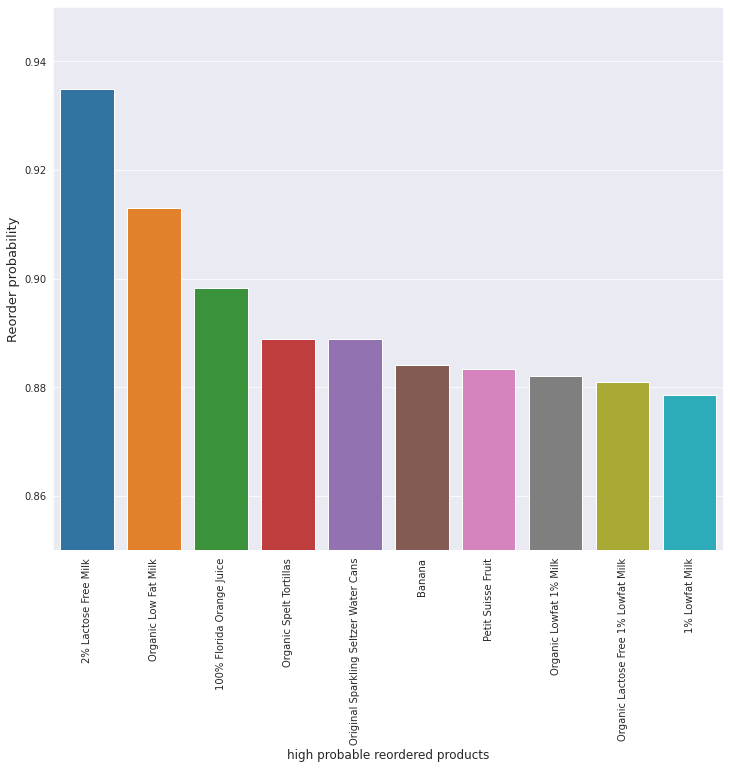

In [20]:
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns
DF_reorder_prob=reorder_prob.toPandas()
color = sns.color_palette()
sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(DF_reorder_prob.product_name, DF_reorder_prob.reorder_probability)
plt.ylim([0.85,0.95])
plt.ylabel('Reorder probability', fontsize=13)
plt.xlabel('high probable reordered products', fontsize=12)
plt.show()

In [21]:
df_departments = spark.read.csv('/content/drive/My Drive/instacart/departments.csv', header=True, sep=',', inferSchema=True)
df_departments.createOrReplaceTempView("departments")
Rankings=spark.sql('SELECT p.product_name AS Products, d.department AS department, COUNT(op.product_id) AS sold_times, ROW_NUMBER() OVER (PARTITION BY department ORDER BY COUNT(op.product_id) DESC) AS Rank'
               ' FROM products p'
               ' INNER JOIN departments d ON d.department_id = p.department_id'
               ' INNER JOIN order_prod op ON op.product_id = p.product_id'
               ' GROUP BY department, Products')
Rankings.createOrReplaceTempView("Ranking")
top_prod=spark.sql('SELECT department, Products,sold_times '
               ' FROM Ranking'
               ' WHERE Rank<=3'
               ' ORDER BY department'
               ' LIMIT 63')
top_prod.show(63,truncate=180)

+---------------+-----------------------------------------------------+----------+
|     department|                                             Products|sold_times|
+---------------+-----------------------------------------------------+----------+
|        alcohol|                                      Sauvignon Blanc|       295|
|        alcohol|                                   Cabernet Sauvignon|       237|
|        alcohol|                                                 Beer|       224|
|         babies|     Baby Food Stage 2 Blueberry Pear & Purple Carrot|       310|
|         babies|                Spinach Peas & Pear Stage 2 Baby Food|       268|
|         babies|                Gluten Free SpongeBob Spinach Littles|       259|
|         bakery|                               100% Whole Wheat Bread|      2298|
|         bakery|                   Organic Bread with 21 Whole Grains|       938|
|         bakery|                                      Sourdough Bread|       738|
|   

# Three top products of departments in one graph

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


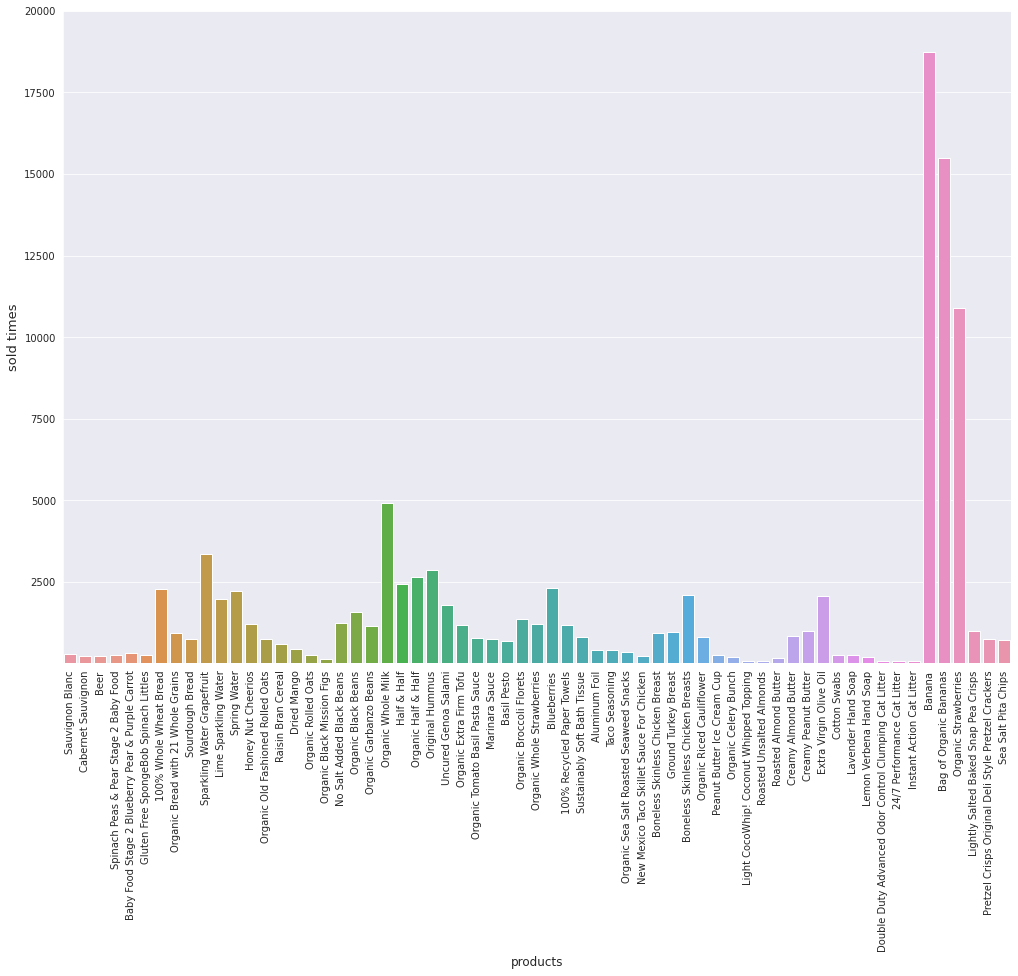

In [30]:
df_top_prod=top_prod.toPandas()
color = sns.color_palette()
sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(17, 12))
plt.xticks(rotation='vertical')
sns.barplot(df_top_prod.Products, df_top_prod.sold_times)
plt.ylim([10,20000])
plt.ylabel('sold times', fontsize=13)
plt.xlabel('products', fontsize=12)
plt.show()



# Three Top product of each department separately graphed

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

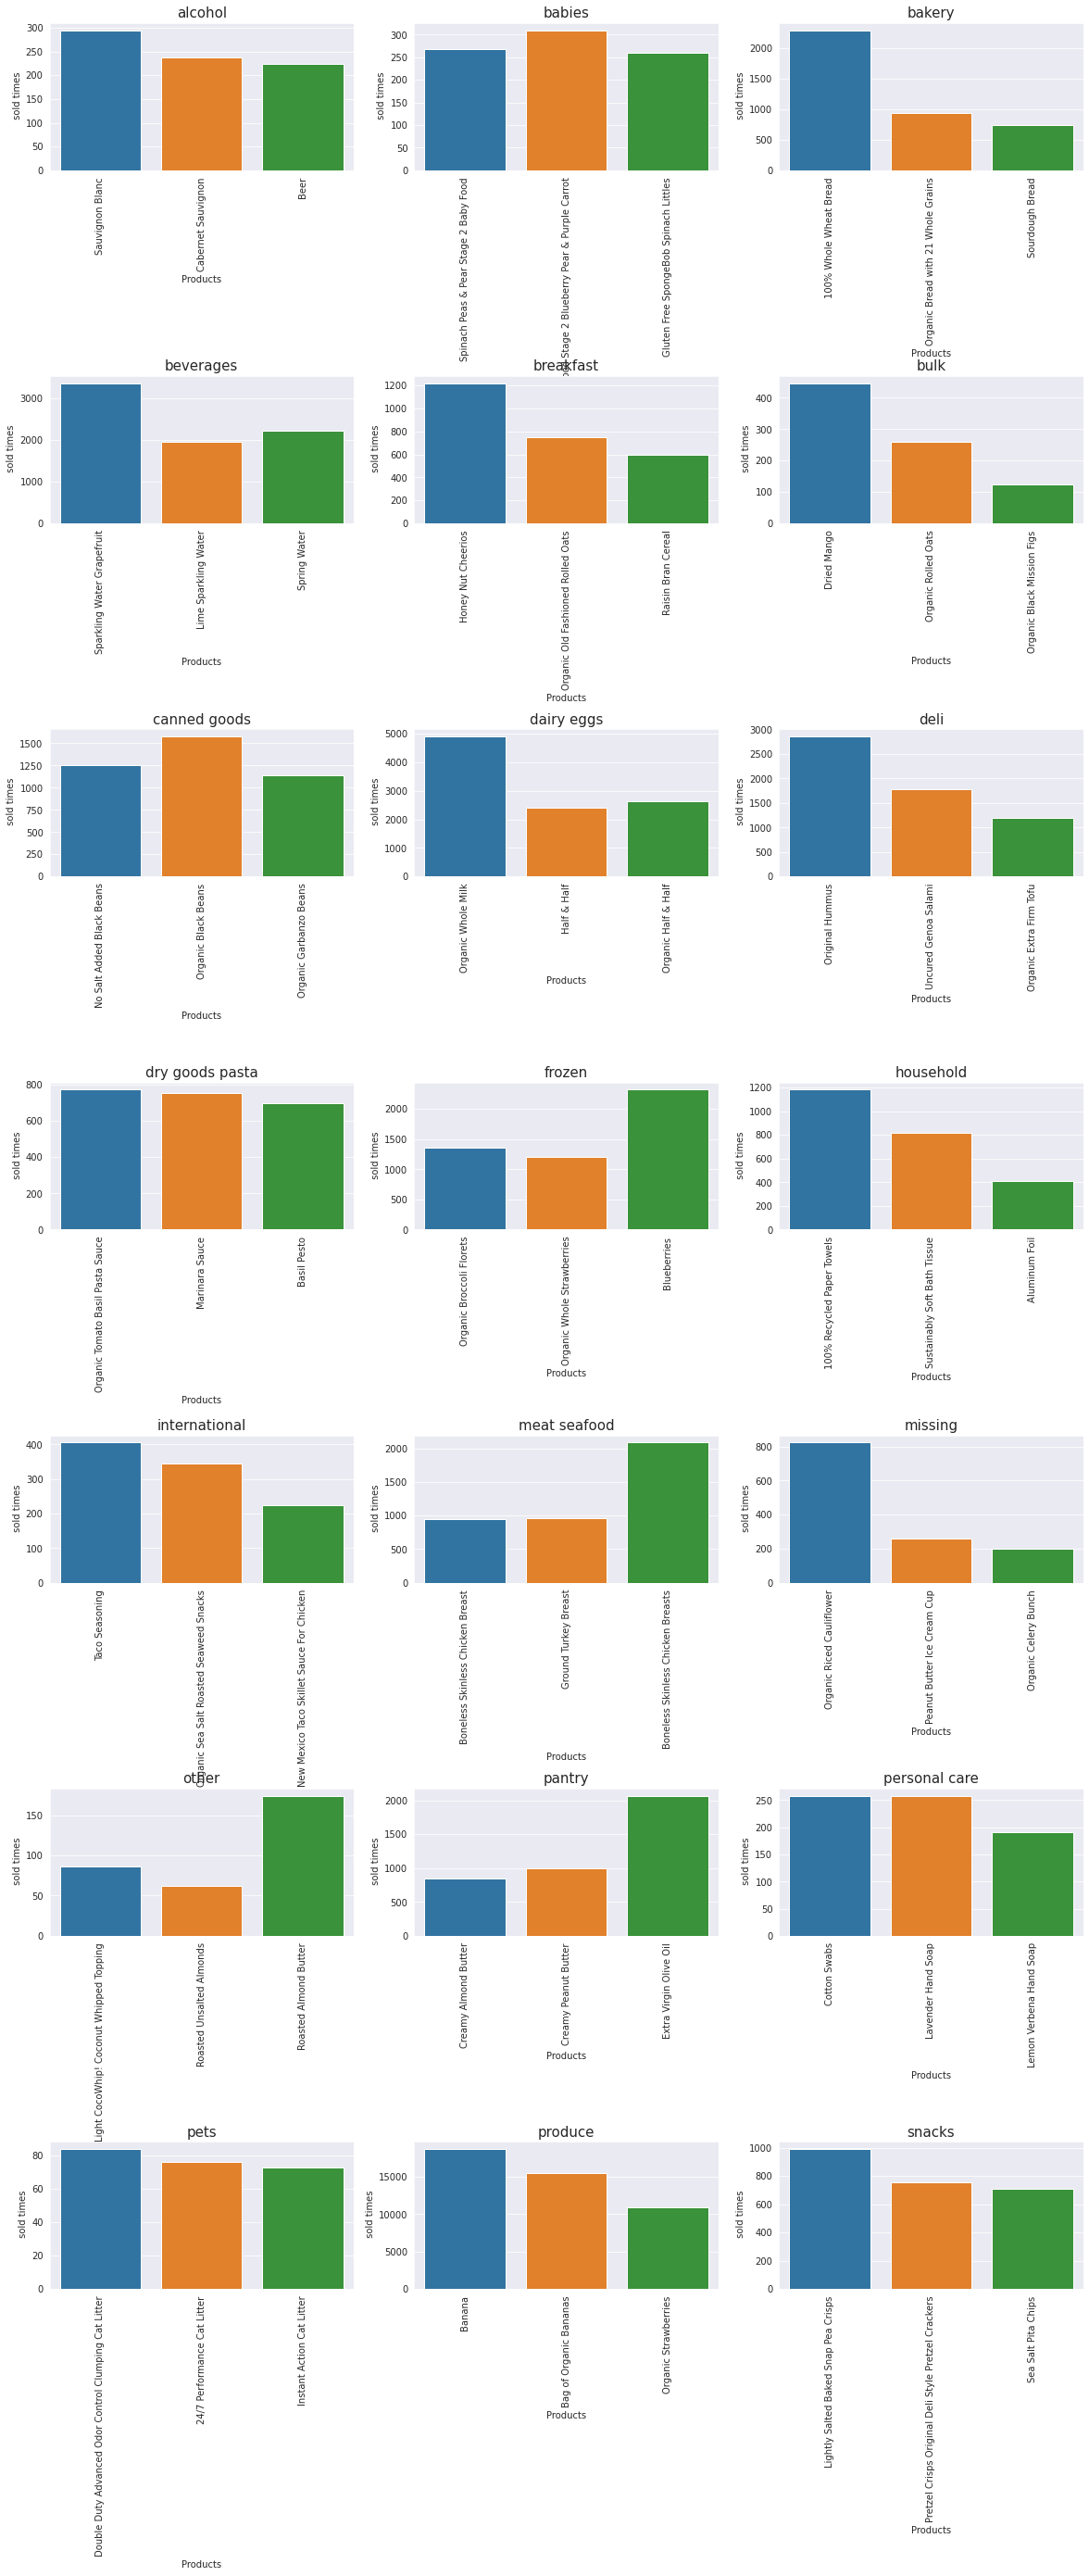

In [46]:

fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
for (products, department), ax in zip(df_top_prod.groupby(df_top_prod.department), axes.flatten()):
    g = sns.barplot(department.Products, department.sold_times , ax=ax)
    ax.set(ylabel=" sold times")
    g.set_xticklabels(labels = department.Products,rotation=90, fontsize=10)
    ax.set_title(products, fontsize=15)

In [50]:
order_DOW=spark.sql('SELECT o.order_dow AS Order_Day, (COUNT(op.product_id)/COUNT(DISTINCT(o.order_id))) AS Average_Basket'
               ' FROM orders o'
               ' INNER JOIN order_prod op ON op.order_id = o.order_id'
               ' GROUP BY Order_Day'
               ' ORDER BY Order_Day')
order_DOW.show()

+---------+------------------+
|Order_Day|    Average_Basket|
+---------+------------------+
|        0|11.797778991443655|
|        1|10.470618137454249|
|        2|  9.96103976673491|
|        3|  9.84133358832154|
|        4| 9.742527727301209|
|        5|10.163736642537057|
|        6|10.966562615734617|
+---------+------------------+



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


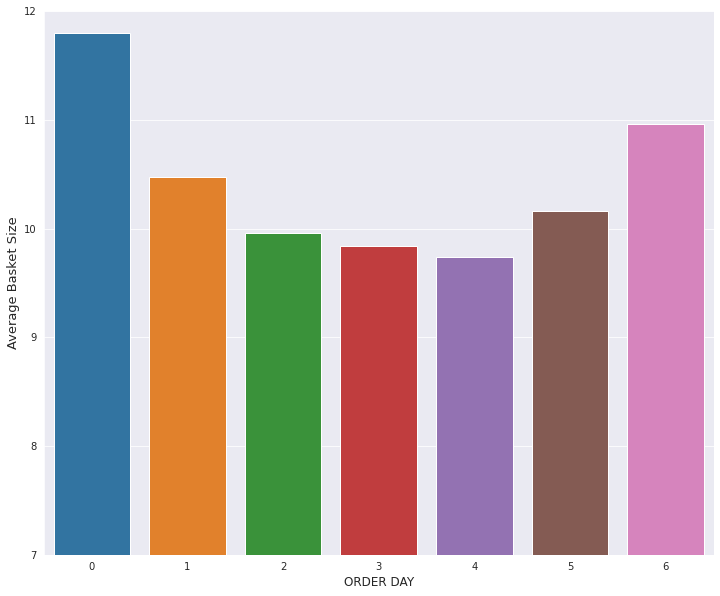

In [22]:
df_order_DOW=order_DOW.toPandas()
color = sns.color_palette()
sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='horizontal')
sns.barplot(df_order_DOW.Order_Day, df_order_DOW.Average_Basket)
plt.ylim([7,12])
plt.ylabel('Average Basket Size', fontsize=13)
plt.xlabel('ORDER DAY', fontsize=12)
plt.show()

### 3.2 Run MBA for the training set (15 points)

Using the orders from the ``order_products__train.csv``, create a data frame where each row contains the column “transaction” with the list of purchased products, similarly to the toy dataset. In sequence, run the MBA algorithm for this set of transactions. 

- You must report the time spent to perform this task.
- Output must contain the products' name.

In [37]:
%%time
"""
TODO: create a query to create and sctruct the transactions
"""

trans_train=spark.sql('SELECT op.order_id, COLLECT_LIST(p.product_name) AS transaction' 
               ' FROM order_prod op '
               ' INNER JOIN products p  ON op.product_id = p.product_id'
               ' GROUP BY  op.order_id ORDER BY op.order_id')
trans_train.show(5, truncate=200)


+--------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|order_id|                                                                                                                                                                                             transaction|
+--------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|       1|[Bulgarian Yogurt, Organic 4% Milk Fat Whole Milk Cottage Cheese, Organic Celery Hearts, Cucumber Kirby, Lightly Smoked Sardines in Olive Oil, Bag of Organic Bananas, Organic Hass Avocado, Organic ...|
|      36|        [Grated Pecorino Romano Cheese, Spring Water, Organic Half & Half, Super Greens Salad, Cage Free Extra Large Grade AA Eggs, Prosciutto

In [38]:
%%time
"""
TODO: run the MBA algorithm and show the first 5 association rules
"""
from itertools import combinations

def format_tuples1(pattern):
   
    return (str(pattern[0]), str(pattern[1]))

def map_to_patterns1(row):
  products = row.transaction
  for i in range(1,4):
    products_comb=combinations(list(products),i)
    for pc in list(products_comb):
        yield (tuple(sorted(pc)), 1)

def reduce_patterns1(value1, value2):
  return value1+value2 

def map_to_subpatterns1(pattern):
    if len(pattern[0])==1:
      yield (pattern[0],(None,pattern[1]))
    else:
      yield (pattern[0],(None,pattern[1]))
      for i in range(len(pattern[0])):
        yield (pattern[0][:i]+pattern[0][i+1:],(pattern[0][i],pattern[1])) 

def map_to_assoc_rules1(rule):
  for r in rule[1]:
      if r[0]==None:
        t=r[1]
        break
  r1=[]
  for r in rule[1]:
    if r[0]!= None:
      r1.append((r[0],r[1]/t))
  yield ((rule[0],r1))

trans_train_rdd = trans_train.rdd
patterns_rdd = trans_train_rdd.flatMap(map_to_patterns1)

combined_patterns_rdd = patterns_rdd.reduceByKey(reduce_patterns1)

subpatterns_rdd = combined_patterns_rdd.flatMap(map_to_subpatterns1)

combined_rules = subpatterns_rdd.groupByKey()

assoc_rules = combined_rules.flatMap(map_to_assoc_rules1)

# Output as dataframe

#patterns_rdd.map(format_tuples1).toDF(['patterns', 'occurrences']).show(50,truncate=280)
#combined_patterns_rdd.map(format_tuples1).toDF(['patterns', 'combined_occurrences']).show(5,truncate=280)
#subpatterns_rdd.map(format_tuples1).toDF(['subpatterns', 'rules']).show(50,truncate=False)
#combined_rules.map(format_tuples1).toDF(['subpatterns', 'combined_rules']).show(200,truncate=False)
assoc_dframe=assoc_rules.map(format_tuples1).toDF(['patterns', 'association_rules'])
assoc_dframe.show(5,truncate=80)
assoc_dframe.createOrReplaceTempView("association_table")


+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|                                                                        patterns|                                                               association_rules|
+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|                           ('Organic Raspberries', 'Organic Whole Strawberries')|[('Toasted Coconut Almondmilk Blend', 0.0091324200913242), ('Plantain Chips',...|
|('Organic Seasoned Yukon Select Potatoes Hashed Browns', 'Whole Milk Greek Bl...|[('Organic Extra Virgin Oil Olive', 0.5), ('Uncured Genoa Salami', 0.5), ('Ba...|
|      ('Organic Chocolate Almondmilk Pudding', 'Organic Extra Virgin Oil Olive')|[('Organic Stringles Mozzarella String Cheese', 1.0), ('Organic Ketchup', 1.0...|
|('Natural Chick

# Randomly choosing a product and searching for its association

In [ ]:
rand_prod1=spark.sql('SELECT   p.product_name AS Random_Product, op.product_id AS ID'
                        ' FROM order_prod op'
                        ' INNER JOIN products p ON p.product_id=op.product_id'
                        ' GROUP BY p.product_name, op.product_id '
                        ' ORDER BY RAND()'
                        ' LIMIT 1')
rand_prod1.show(truncate=False)
a=list(map(lambda row: row[0], rand_prod1.rdd.takeSample(False, 1)))
b=a[0]
print(b)
print(a)
def search_table(rule):
  if rule[0].replace("'","").replace("(","").replace(")","").replace(",","")==b:
    yield(rule[1])
assoc_dframe_rdd=assoc_dframe.rdd
tab_rand=assoc_dframe_rdd.flatMap(search_table)
print(tab_rand.collect())
#tab_rand.map(format_tuples).toDF(['products', 'association_rules']).show(150,truncate=150)

+--------------------+----+
|      Random_Product|  ID|
+--------------------+----+
|Lite Chunky Blue ...|6127|
+--------------------+----+

Lite Chunky Blue Cheese Dressing and Dip
['Lite Chunky Blue Cheese Dressing and Dip']
['[(\'Pure & Natural Sour Cream\', 0.5), (\'Golden Brown All Natural Mild Sausage Links\', 0.5), (\'Red Peppers\', 0.5), (\'Boneless And Skinless Chicken Breast\', 0.5), (\'Mustard, Sweet Hot\', 0.5), (\'Flour Tortilla\', 0.5), (\'Whole Milk\', 0.5), (\'Organic Tomato Cluster\', 0.5), (\'Crumbled Blue Cheese\', 0.5), (\'Green Bell Pepper\', 0.5), ("Hot \'N Spicy Wings", 0.5), (\'Fajitas Spices & Seasonings\', 0.5), (\'Lemon-Lime Soda\', 0.5), (\'Lemon-Lime 12 Pack Soda\', 0.5), (\'Creamy Peanut Butter Dark Roasted\', 0.5), (\'Medium Roast Original Blend Ground Coffee\', 0.5), (\'The Original Thick Slice with Real Garlic Texas Toast\', 0.5), (\'Russet Potato\', 0.5), (\'Red Hot Buffalo Wings Sauce\', 0.5)]']


# 3.3 Run MBA for the whole dataset (20 points)

As you probably noticed, even for a not so large data set (the training file has only 131K orders), the MBA algorithm is computationally expensive. For that reason, this time, we will repeat the process, but now using the Amazon Web Services (AWS) to create a large computer cluster. All the instructions for creating a computing cluster with spark and how to submit a job will be explained in the laboratory. In any case, you should read the instructions given in the ``Instruction_AWS.pdf``.

This time, we will work with the ``order_products__prior.csv`` file, which contains more than 3M orders.

**EXPECTED OUTPUT**

After you ran the MBA for the larger collection of orders, randomly select ONE product purchased in ``order_products__prior`` and print the association rules (product name and association value) of this product, i.e., when the product is alone in the basket. The output should be formatted in a table, where each row containing the information of one associated product.

- Print both ID and Name of the random selected product.
- Report the execution time.

In [ ]:
%%time
"""
TODO: create a query to create and sctruct the transactions from the order_products__prior.csv file
"""
df_order_prod = spark.read.csv('/content/drive/My Drive/instacart/order_products__prior.csv', header=True, sep=',', inferSchema=True)

df_orders = spark.read.csv('/content/drive/My Drive/instacart/orders.csv', header=True, sep=',', inferSchema=True)

df_products = spark.read.csv('/content/drive/My Drive/instacart/products.csv', header=True, sep=',', inferSchema=True)

df_order_prod.createOrReplaceTempView("order_prod_prior") # creates table 'order_prod_prior'
df_orders.createOrReplaceTempView("orders") # creates table 'orders'
df_products.createOrReplaceTempView("products") # creates table 'products'

trans_prior=spark.sql('SELECT op.order_id, COLLECT_LIST(p.product_name) AS transaction' 
               ' FROM order_prod_prior op '
               ' INNER JOIN products p  ON op.product_id = p.product_id'
               ' GROUP BY  op.order_id ORDER BY op.order_id')
trans_prior.show(5, truncate=200)


+--------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|order_id|                                                                                                                                                                                             transaction|
+--------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|       2|[Organic Egg Whites, Michigan Organic Kale, Garlic Powder, Coconut Butter, Natural Sweetener, Carrots, Original Unflavored Gelatine Mix, All Natural No Stir Creamy Almond Butter, Classic Blend Cole...|
|       3|[Total 2% with Strawberry Lowfat Greek Strained Yogurt, Unsweetened Almondmilk, Lemons, Organic Baby Spinach, Unsweetened Chocolate Almond Bre

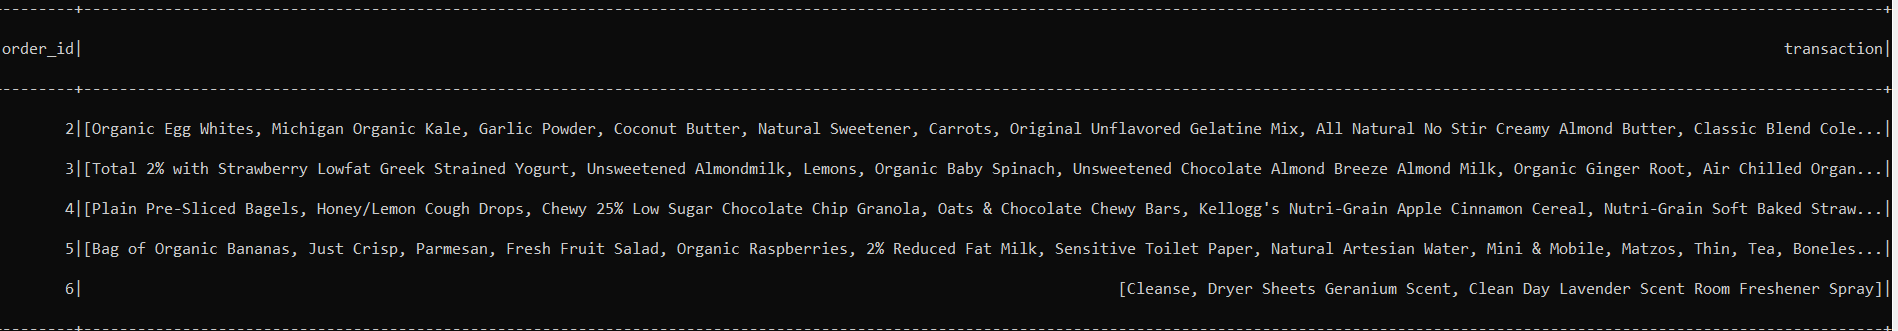

In [ ]:
%%time
"""
TODO: run the MBA algorithm and print the requested output
"""
from itertools import combinations

def format_tuples1(pattern):
   
    return (str(pattern[0]), str(pattern[1]))

def map_to_patterns1(row):
    products = row.transaction
    for i in range(1,4):
        products_comb=combinations(list(products),i)
        for pc in list(products_comb):
          yield (tuple(sorted(pc)), 1)

def reduce_patterns1(value1, value2):
    return value1+value2 

def map_to_subpatterns1(pattern):
    if len(pattern[0])==1:
        yield (pattern[0],(None,pattern[1]))
    else:
        yield (pattern[0],(None,pattern[1]))
        for i in range(len(pattern[0])):
            yield (pattern[0][:i]+pattern[0][i+1:],(pattern[0][i],pattern[1])) 

def map_to_assoc_rules1(rule):

    for r in rule[1]:
        if r[0]==None:
            t=r[1]
            list(rule[1]).remove(r)
    r1=[(r[0],r[1]/t) for r in rule[1]]
    yield ((rule[0],r1))    

trans_train_rdd = trans_train.rdd
patterns_rdd = trans_train_rdd.flatMap(map_to_patterns1)

combined_patterns_rdd = patterns_rdd.reduceByKey(reduce_patterns1)

subpatterns_rdd = combined_patterns_rdd.flatMap(map_to_subpatterns1)

combined_rules = subpatterns_rdd.groupByKey()

assoc_rules = combined_rules.flatMap(map_to_assoc_rules1)


#patterns_rdd.map(format_tuples1).toDF(['patterns', 'occurrences']).show(50,truncate=280)
#combined_patterns_rdd.map(format_tuples1).toDF(['patterns', 'combined_occurrences']).show(5,truncate=280)
#subpatterns_rdd.map(format_tuples1).toDF(['subpatterns', 'rules']).show(50,truncate=False)
#combined_rules.map(format_tuples1).toDF(['subpatterns', 'combined_rules']).show(200,truncate=False)
assoc_dframe=assoc_rules.map(format_tuples1).toDF(['patterns', 'association_rules'])
assoc_dframe.show(5,truncate=80)
assoc_dframe.createOrReplaceTempView("assoc_rule")

In [ ]:
rand_prod1=spark.sql('SELECT   p.product_name AS Random_Product, op.product_id AS ID'
                        ' FROM order_prod_prior op'
                        ' INNER JOIN products p ON p.product_id=op.product_id'
                        ' GROUP BY p.product_name, op.product_id '
                        ' ORDER BY RAND()'
                        ' LIMIT 1')
rand_prod1.show(truncate=False)
a=list(map(lambda row: row[0], rand_prod1.rdd.takeSample(False, 1)))
b=a[0]

def search_table(rule):
  if rule[0].replace("'","").replace("(","").replace(")","").replace(",","")==b:
    yield(rule[1])
assoc_dframe_rdd=assoc_dframe.rdd
tab_rand=assoc_dframe_rdd.flatMap(search_table)
print(tab_rand.collect())

**Please note that we have used M5.xlarge instances which seems not enough to run .groupbykey(). We have managed to obtain subpatterns_rdd dataframe but the rest of operation crashes. We have run the random search for the train dataset as well.**

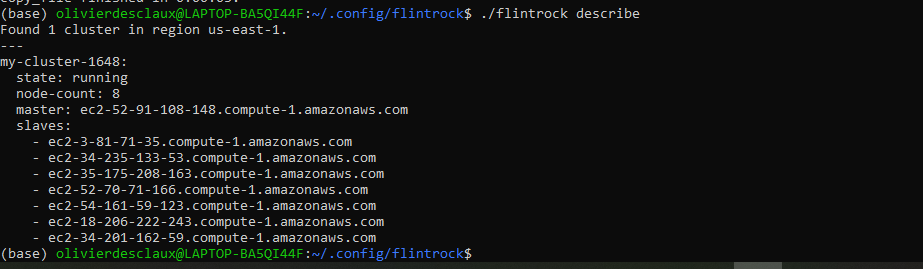

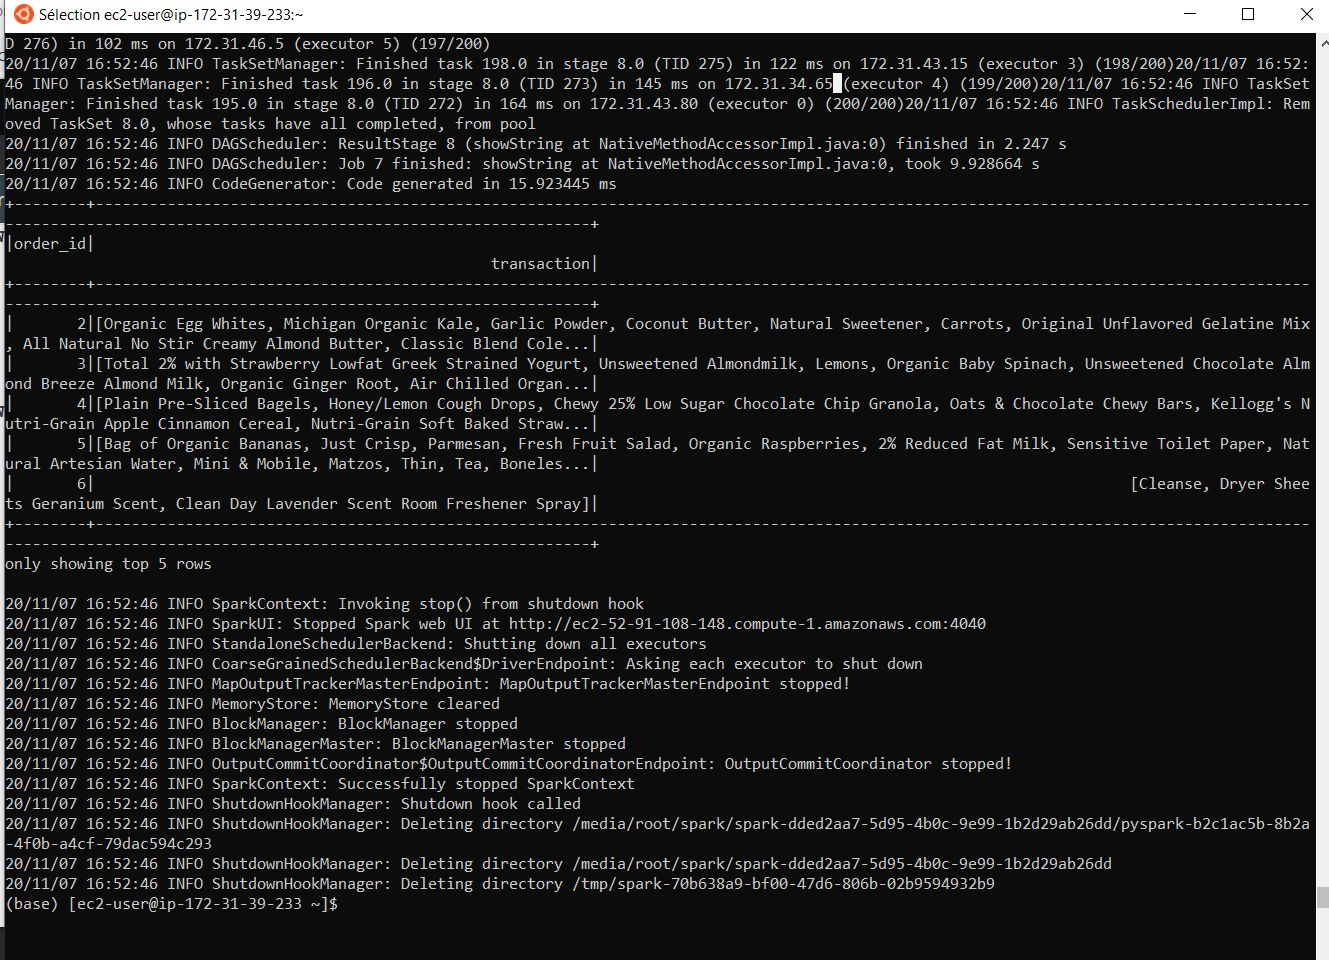

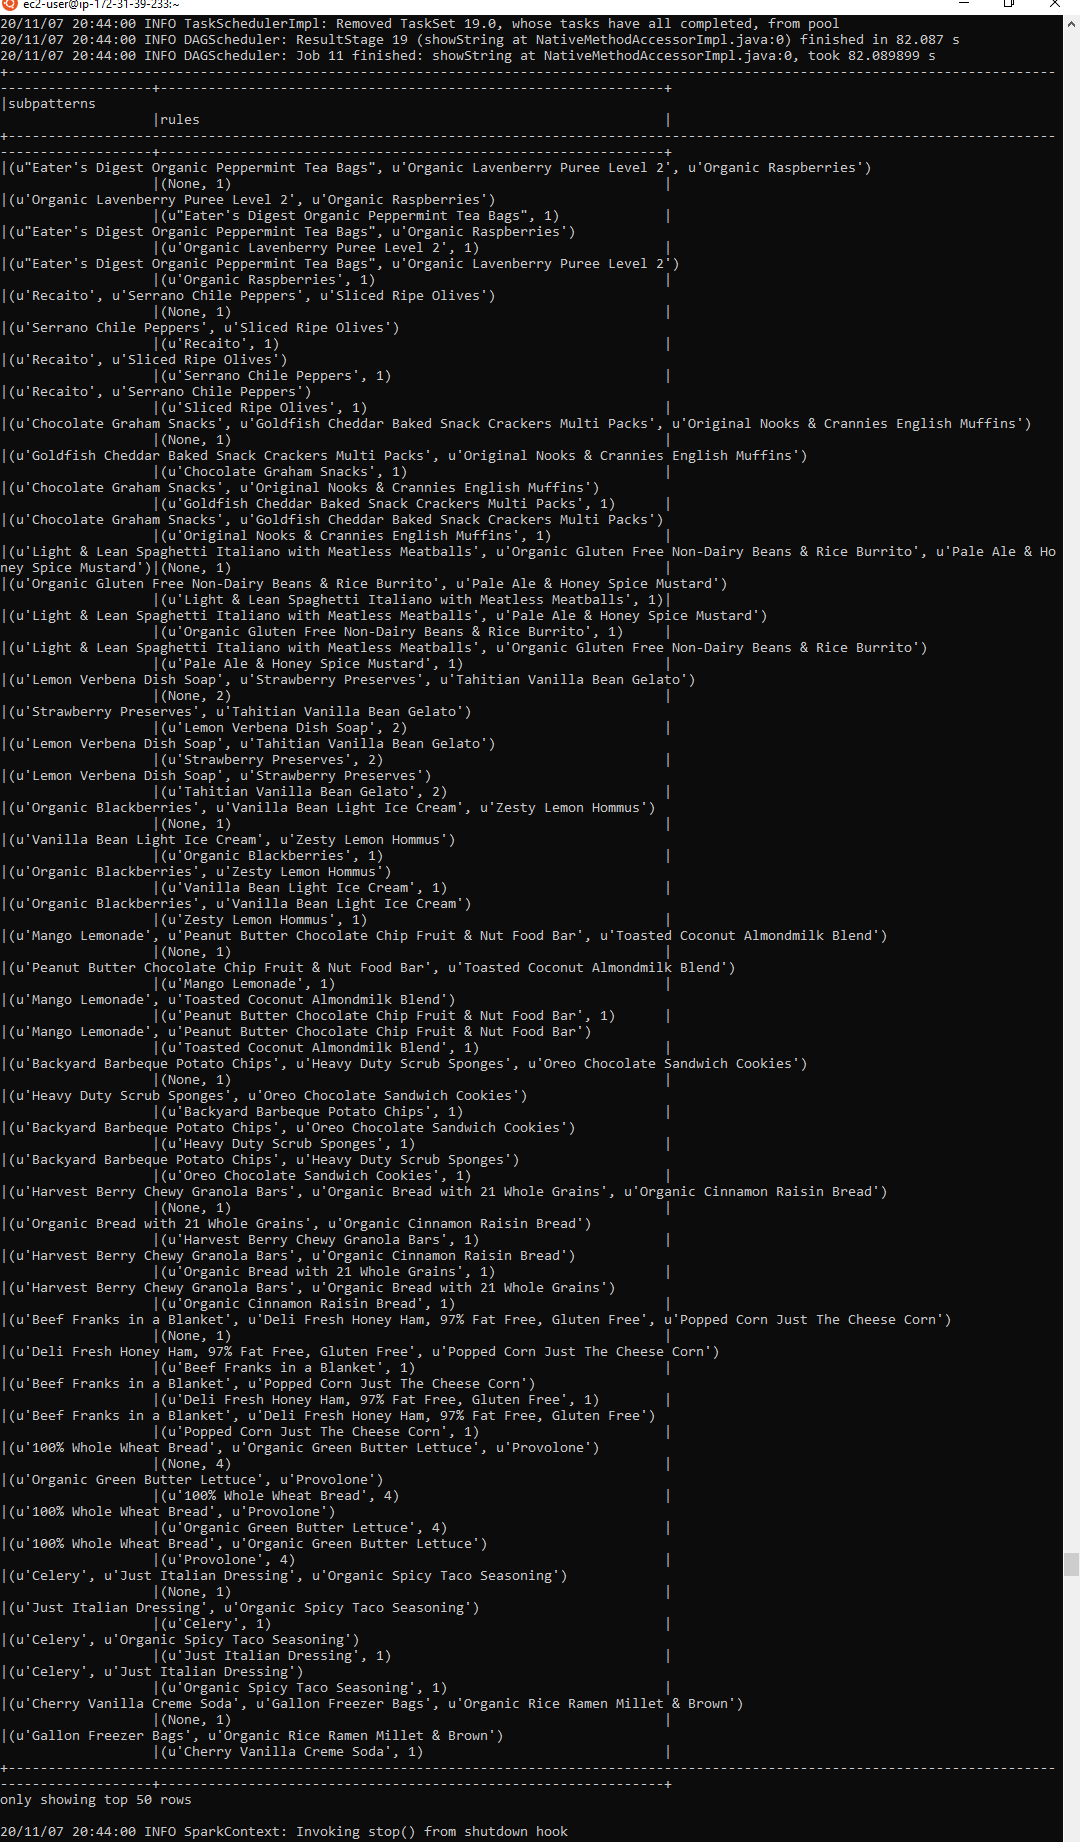